# Materials Project

This project aims to apply unsupervised learning techniques to materials data from the Materials Project, a database that provides a wealth of information on various materials, including their properties, compositions, and structures. The goal is to discover hidden patterns, group similar materials, and identify potentially novel materials or relationships between material properties.

This [data](https://figshare.com/articles/dataset/Materials_Project_Data/7227749?file=13309250) was extracted from the Materials Project by Anubhav Jain and others.

Import neccesary libraries:

In [2]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

First, we will read the csv file into a pandas data frame.

In [3]:
materials_data = pd.read_csv('mp_nostruct.csv')
materials_data.head(10)

,material_id,pretty_formula,e_above_hull,band_gap,total_magnetization,elasticity.elastic_anisotropy,elasticity.K_VRH,elasticity.G_VRH,energy,energy_per_atom,formation_energy_per_atom
0,mp-85,In,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,-2.721563,-2.721563,0.003319
1,mp-110,Mg,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,-1.565153,-1.565153,0.039182
2,mp-20,Be,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,-14.537871,-3.634468,0.108143
3,mp-8640,Hf,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,-9.883049,-9.883049,0.071216
4,mp-674158,P,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,-1.895193,-1.895193,3.509988
5,mp-979286,Xe,0.005612,6.1701,0.000000e+00,NaN,NaN,NaN,-0.030139,-0.030139,0.005612
6,mp-982872,Hg,0.020462,0.0000,-2.800000e-06,NaN,NaN,NaN,-0.283229,-0.283229,0.020462
7,mp-673171,Br,0.615956,0.0000,-1.807400e-03,-60.573886,21.044759,-18.850184,-1.013059,-1.013059,0.615956
8,mp-95,Sr,0.008637,0.0000,-1.827100e-03,8.702322,11.543947,6.232662,-1.677328,-1.677328,0.008637
9,mp-972256,Xe,0.000000,6.1671,1.040000e-05,NaN,NaN,NaN,-0.035751,-0.035751,0.000000


In [4]:
print(len(materials_data))

83989


## Outlier Detection

The first analysis we will make is outlier detection: which materials can be identified as outliers in the data? For this, we will be using the isolation forest algorithm. First lets use all of the features and see if there are any outliers

In [3]:
def isolation_forest(data, features):
    '''
    This function performs the isolation forest algorithm

    Parameters
    ----------
    data : pd.DataFrame
        The data frame that we will perform the isolation forest on.
    features : list
        List of feature names

    Returns
    -------
    anomaly_scores : np.array
        array of anomaly scores
    anomalies : DataFrame
        array of 1's and 0's where 1 is an anomaly, 0 is an inlier
    X_Scaled : DataFrame
        contains scaled data
    X : DataFrame
        contains all data 
    '''
    X = data[features]
    X = X.fillna(X.median())
    
    # scale the data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # construct and train the model
    model = IsolationForest(random_state=42)
    X_scaled = pd.DataFrame(X_scaled,columns=features)
    model.fit(X_scaled)

    # predict outliers
    anomalies = model.predict(X_scaled)
    anomalies = (anomalies == -1).astype(int)
    anomaly_scores = model.decision_function(X_scaled)
    return X, X_scaled, anomalies, anomaly_scores
    
all_features = ['e_above_hull',
            'band_gap','total_magnetization',
            'elasticity.elastic_anisotropy',
            'elasticity.K_VRH',
            'elasticity.G_VRH',
            'energy',
            'energy_per_atom',
            'formation_energy_per_atom']

# find how many anomalies there are including all features
anomalies = isolation_forest(materials_data, all_features)[2]
count_anomalies = sum(anomalies)

print(f'The number of materials classfied as anamolies is: {count_anomalies}')

The number of materials classfied as anamolies is: 4056


Using automatic contamination, 4056 materials are classified as anomalies. This takes into account all of the features in the all_features list. Let's look at some examples of anomalous materials.

In [16]:
materials_data['anomaly'] = anomalies

anomalous_materials = materials_data.loc[materials_data['anomaly']==1]

anomalous_materials.head(50)

,material_id,pretty_formula,e_above_hull,band_gap,total_magnetization,elasticity.elastic_anisotropy,elasticity.K_VRH,elasticity.G_VRH,energy,energy_per_atom,formation_energy_per_atom,anomaly
4,mp-674158,P,3.509988e+00,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,-1.895193,-1.895193,3.509988e+00,1
5,mp-979286,Xe,5.611940e-03,6.1701,0.000000e+00,NaN,NaN,NaN,-0.030139,-0.030139,5.611940e-03,1
7,mp-673171,Br,6.159556e-01,0.0000,-1.807400e-03,-60.573886,21.044759,-18.850184,-1.013059,-1.013059,6.159556e-01,1
8,mp-95,Sr,8.636890e-03,0.0000,-1.827100e-03,8.702322,11.543947,6.232662,-1.677328,-1.677328,8.636890e-03,1
9,mp-972256,Xe,0.000000e+00,6.1671,1.040000e-05,NaN,NaN,NaN,-0.035751,-0.035751,0.000000e+00,1
10,mp-73,Ti,1.144893e-01,0.1069,1.560000e-05,-4.980000,105.000000,1287.000000,-7.782638,-7.782638,1.144893e-01,1
12,mp-1,Cs,1.608340e-03,0.0000,2.568000e-04,104.159480,1.712808,0.439863,-0.858819,-0.858819,1.608340e-03,1
17,mp-684663,I,4.551378e-01,0.0000,1.431600e-03,-124.884186,26.059576,-15.011857,-1.063921,-1.063921,4.551379e-01,1
18,mp-979285,Xe,1.510940e-03,6.2366,0.000000e+00,NaN,NaN,NaN,-0.034240,-0.034240,1.510940e-03,1
22,mp-23155,Ar,0.000000e+00,8.5108,-1.230000e-05,0.913726,0.835062,0.292940,-0.068792,-0.068792,0.000000e+00,1


At first it may seem surprising that a lot of these materials are single elements or very simple compounds. However if we consdier every material, most of them are more complex compounds. A single element will differ a lot from a complex compound in terms of properties such as total energy.

Next we will create a plot using t-SNE to reduce dimensions.

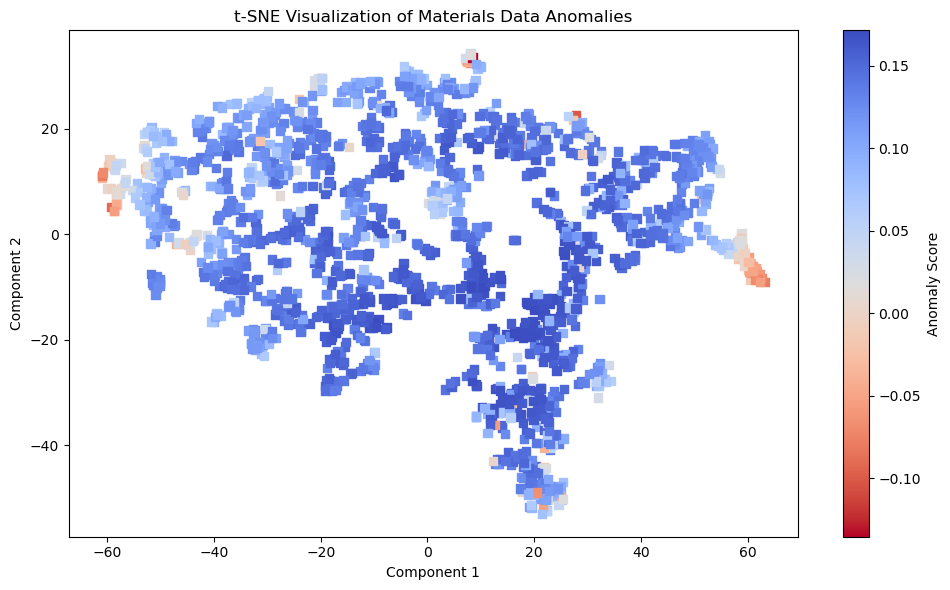

In [5]:
def TSNE_plot1():
    '''
    This function creates a t-SNE scatter plot with anomaly score color coding.

    Parameters
    ----------
    None.

    '''
    X, X_scaled, anomalies, anomaly_scores = isolation_forest(materials_data, all_features)
    
    # perform t-SNE on a sample of the data
    tnse = TSNE(n_components=2, random_state=0)
    
    # sample 2000 rows from X_scaled
    sample_indices = np.random.choice(X_scaled.shape[0], size=2000, replace=False)
    X_scaled_sample = X_scaled.iloc[sample_indices]
    anomaly_scores_sample = anomaly_scores[sample_indices]
    
    # apply t-SNE
    X_tnse = tnse.fit_transform(X_scaled_sample)
    
    # create DataFrame for plotting
    df_tnse = pd.DataFrame(data=X_tnse, columns=['C1', 'C2'])
    df_tnse['anomaly_score'] = anomaly_scores_sample
    
    # plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_tnse['C1'], df_tnse['C2'], c=df_tnse['anomaly_score'], marker='s', cmap='coolwarm_r')
    
    # Add colorbar and labels
    plt.colorbar(scatter, label='Anomaly Score')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('t-SNE Visualization of Materials Data Anomalies')
    
    plt.tight_layout()
    plt.savefig('TSNE_plot1.png', dpi=300)
    plt.show()

TSNE_plot1()

Next we will plot a few pairs of features, then a pairplot of all features. We will also construct a correlation matrix to examine which properites are correlated.

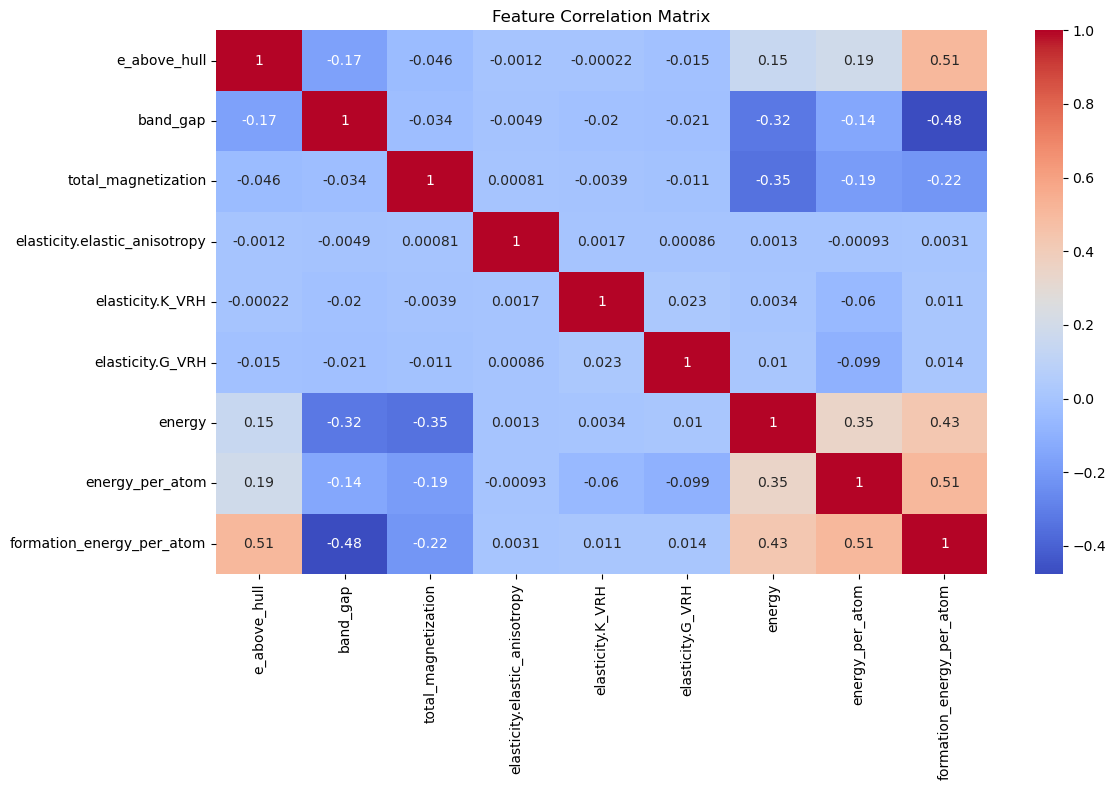

In [6]:
def make_correlation_matrix():
    '''
    This function creates and plots a correlation matrix between all features.

    Parameters
    ----------
    None.

    '''
    X = isolation_forest(materials_data, all_features)[0]
    correlation_matrix = X.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.savefig('feature_correlation_matrix',dpi=300)
    plt.show()
    
make_correlation_matrix()

As we can see, most features are uncorrelated with one another, with the highest correlation being r = 0.51, and the lowest being r = -0.48. Lets plot some of the more correlated values, as well as uncorrelated values.

In [7]:
def scatter(features):
    '''
    This function creates a scatter plot with anomaly score color coding.

    Parameters
    ----------
    features : list
        List of feature names

    '''
    # get data
    X, X_scaled, anomalies, anomaly_scores = isolation_forest(materials_data, features)

    # sample data
    sample_indices = np.random.choice(X_scaled.shape[0], size=2000, replace=False)
    X_scaled_sample = X_scaled.iloc[sample_indices]
    anomaly_scores_sample = anomaly_scores[sample_indices]

    # dataframe of sample data
    df_sample = pd.DataFrame(X_scaled_sample, columns=features)
    df_sample['anomaly_score'] = anomaly_scores_sample

    plt.figure(figsize=(10, 6))

    # scatter plot with anomaly score as hue (centered at 0)
    scatter = plt.scatter(df_sample[features[0]],df_sample[features[1]], c=df_sample['anomaly_score'], marker='s',cmap='coolwarm_r',vmin=-0.2,vmax=0.2)
    cbar = plt.colorbar(scatter,label='Anomaly Score')

    # limits
    x_max, x_min = max(df_sample[features[0]]), min(df_sample[features[0]])
    y_max, y_min = max(df_sample[features[1]]), min(df_sample[features[1]])
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    
    # labels and p value annotation
    plt.xlabel(f'{features[0]} (scaled)')
    plt.ylabel(f'{features[1]} (scaled)')
    plt.title(f'{features[0]} vs. {features[1]} scatter plot')

    pearson_r, p_value = stats.pearsonr(df_sample[features[0]],df_sample[features[1]])
    annotation = f'r = {round(pearson_r,4)}\np = {round(p_value,4)}'
    plt.annotate(annotation,(0.85,0.9),xycoords='axes fraction')

    # save fig
    plt.tight_layout()
    plt.savefig(f'{features[0]}_vs_{features[1]}_anomaly',dpi=300)
    plt.show()

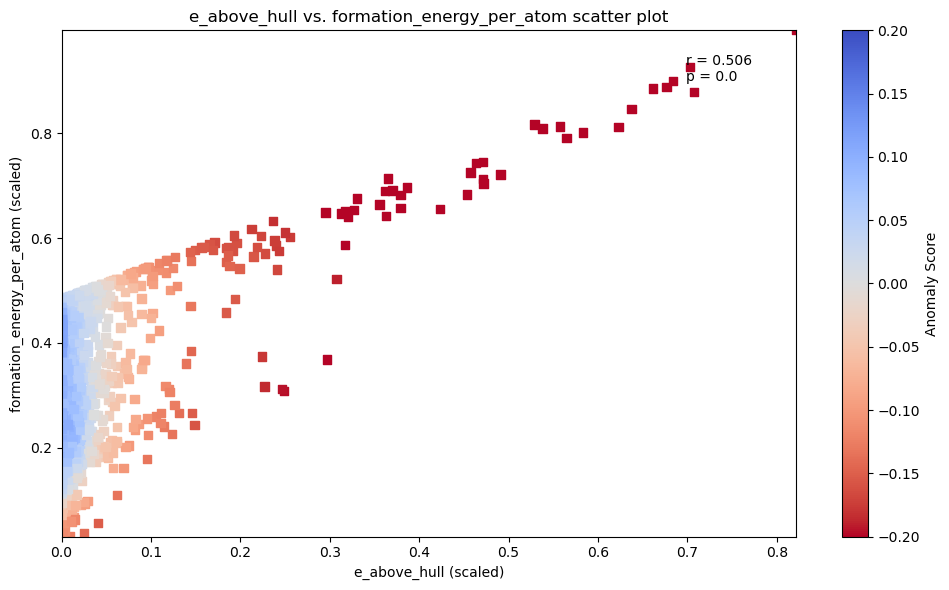

In [8]:
scatter(['e_above_hull','formation_energy_per_atom'])

The reasoning for this correlation could be that higher energy materials tend to be less stable (e_above_hull signifies stability).

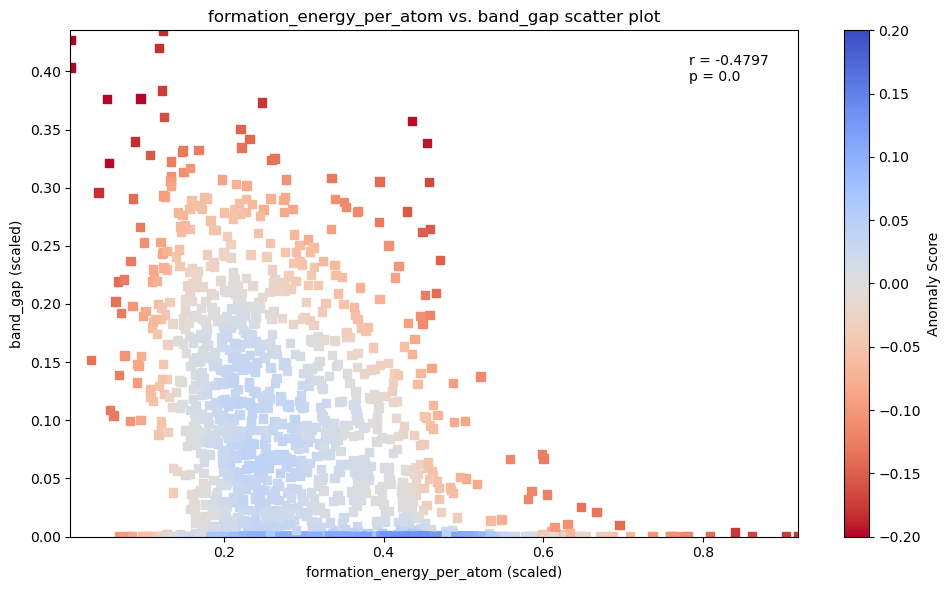

In [9]:
scatter(['formation_energy_per_atom','band_gap'])

The slight negative correlation here is not straightforward, and is material specific.

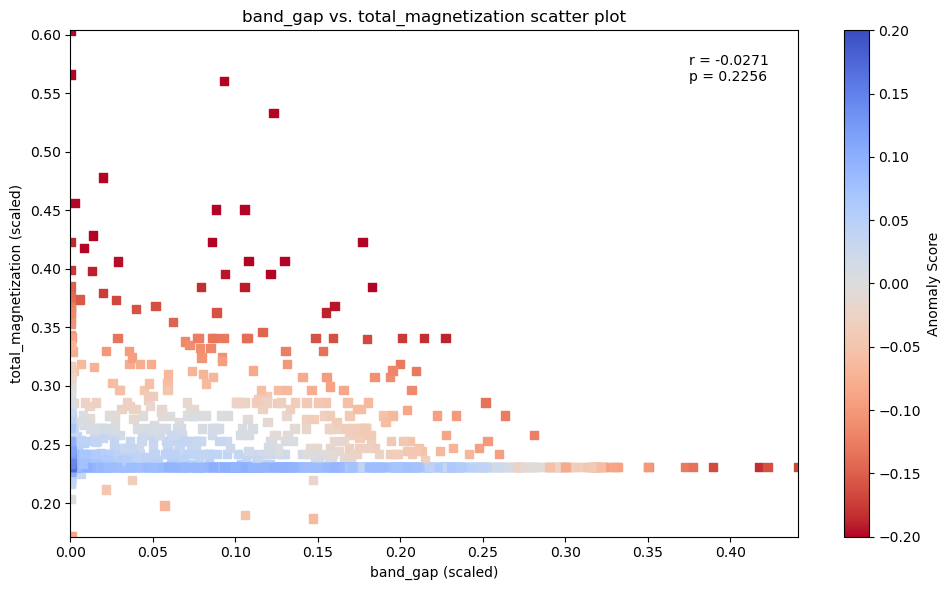

In [10]:
scatter(['band_gap','total_magnetization'])

This is an example of two features with no correlation.

Next lets create a pairplot of all the features.

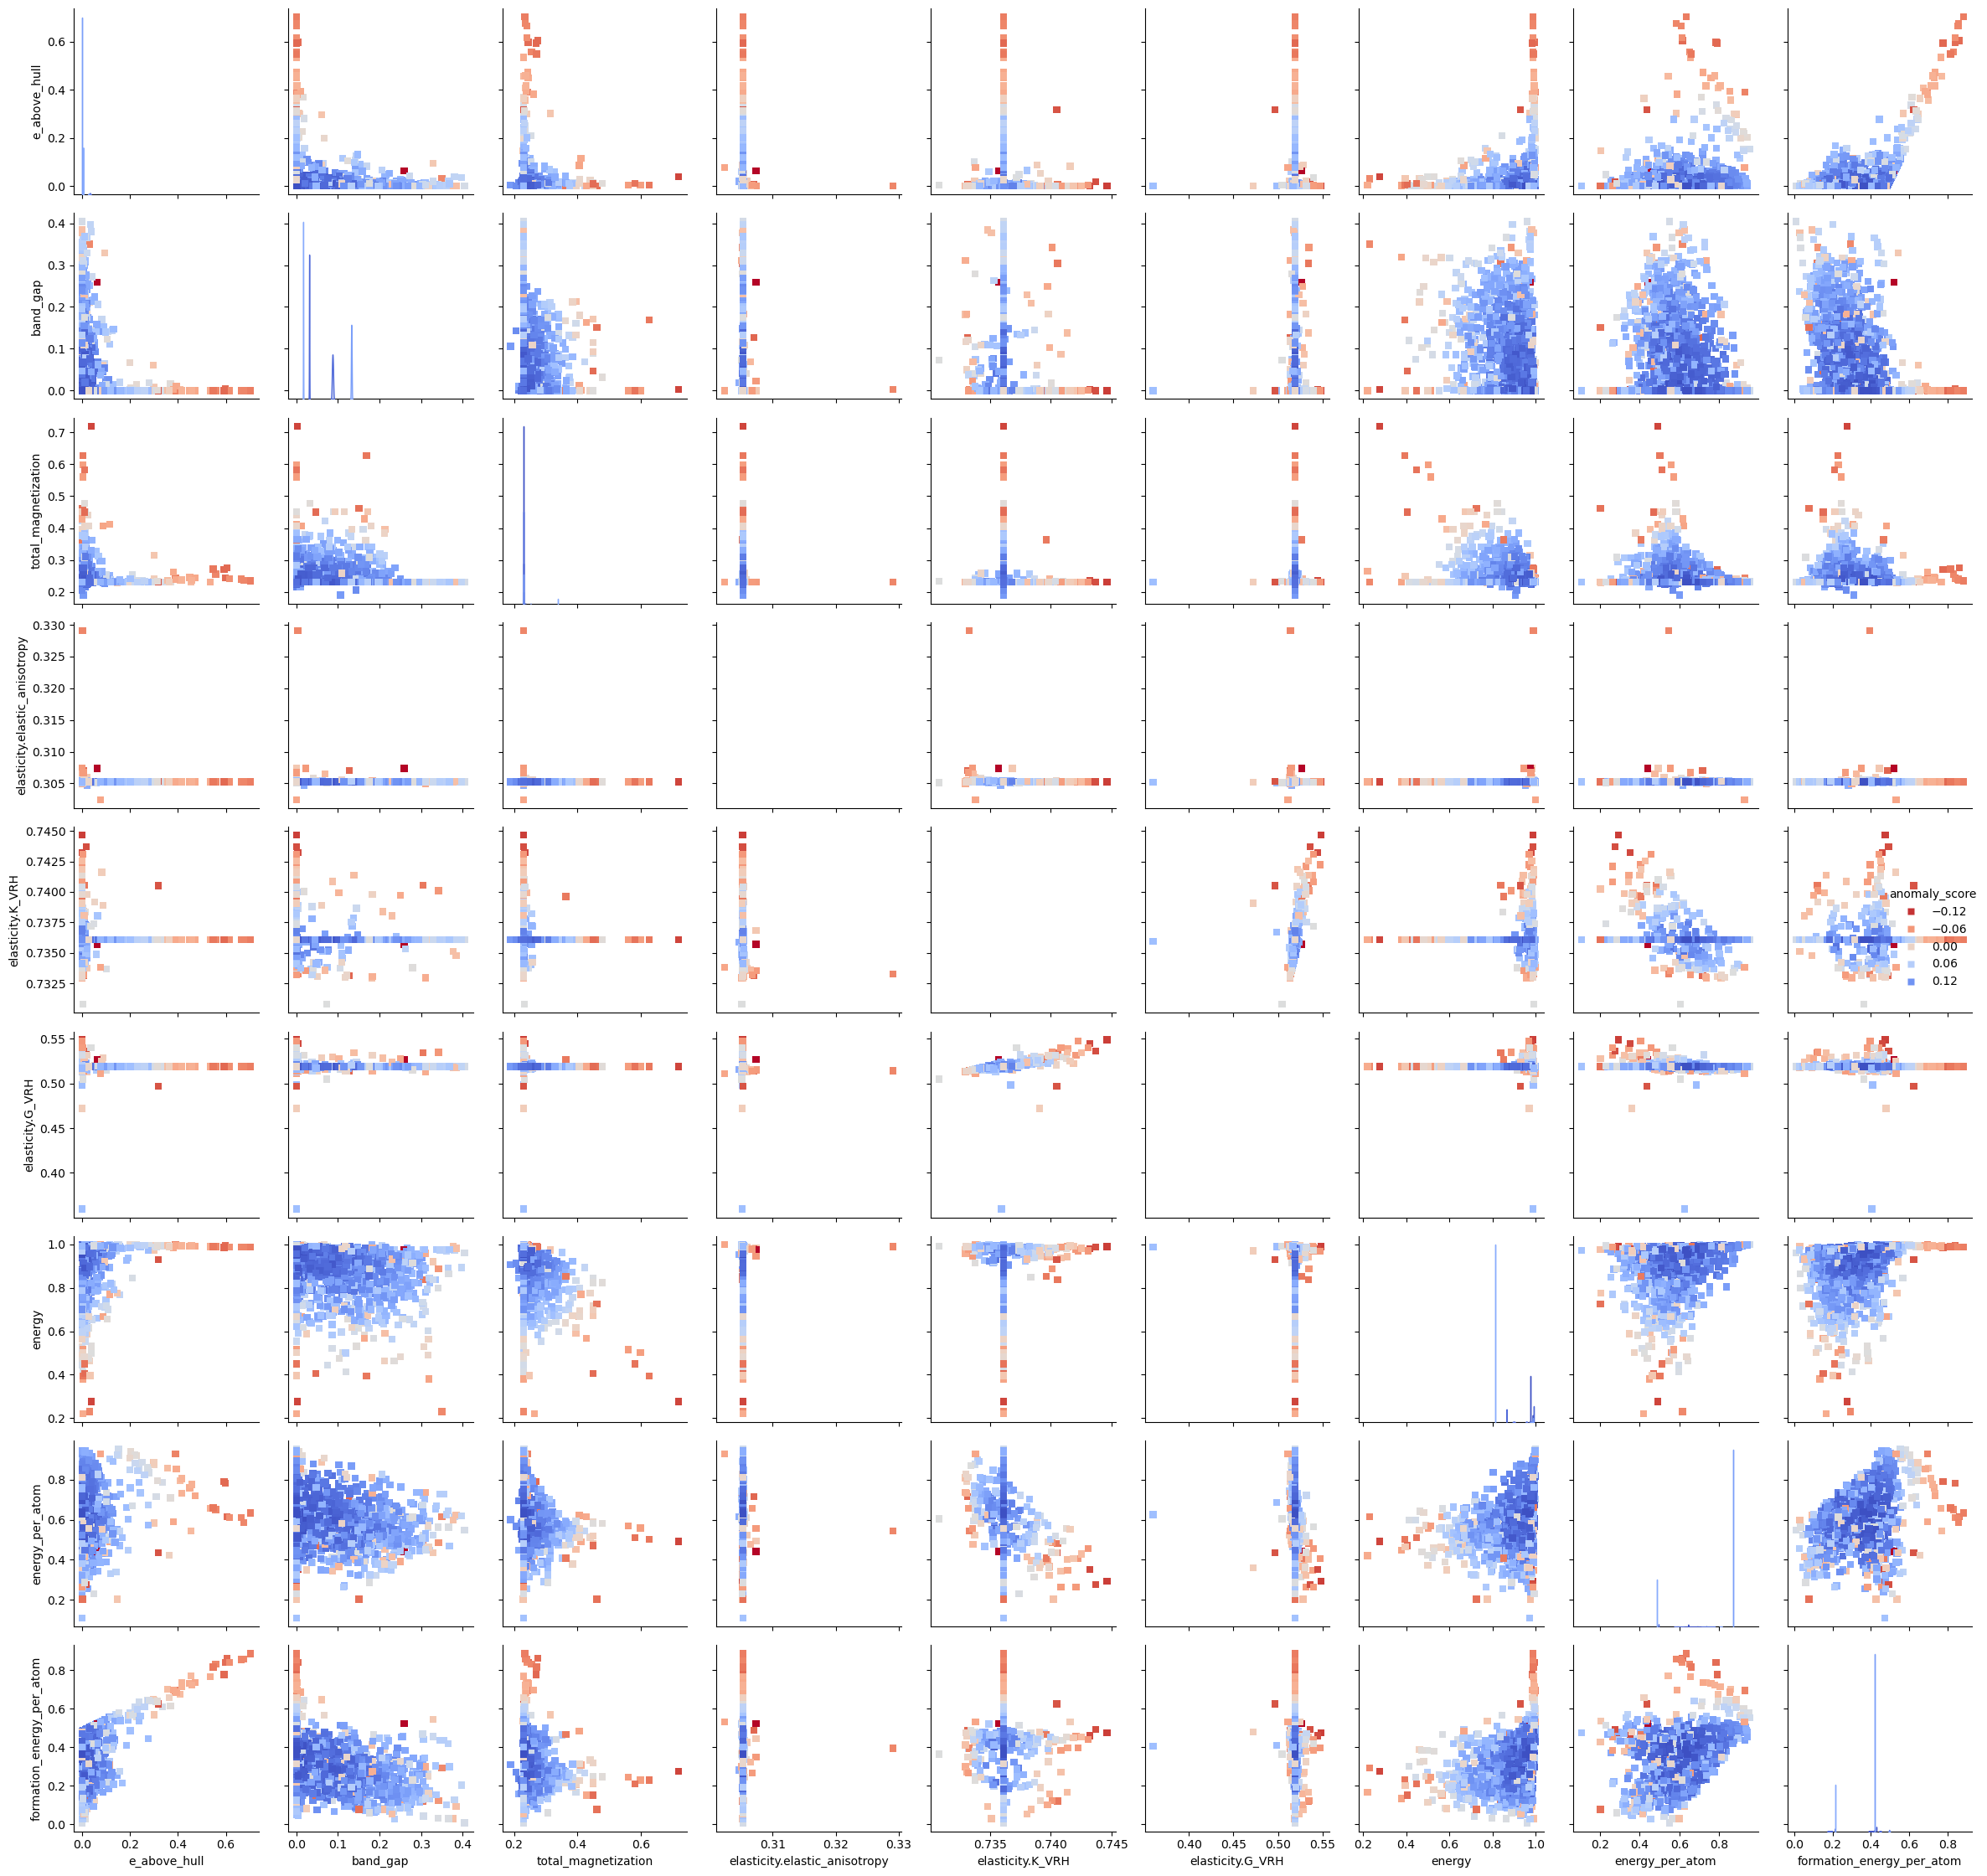

In [11]:
def pairplot(features):
    '''
    This function performs the isolation forest algorithm

    Parameters
    ----------
    features : list
        List of feature names

    '''
    # get data
    X, X_scaled, anomalies, anomaly_scores = isolation_forest(materials_data, features)

    sample_indices = np.random.choice(X_scaled.shape[0], size=2000, replace=False)
    X_scaled_sample = X_scaled.iloc[sample_indices]
    anomaly_scores_sample = anomaly_scores[sample_indices]

    
    df_sample = pd.DataFrame(X_scaled_sample, columns=features)
    df_sample['anomaly_score'] = anomaly_scores_sample
    
    # plot using pairplot with continuous hue
    pairplot = sns.pairplot(df_sample, hue='anomaly_score', palette='coolwarm_r',markers='s',plot_kws=dict(edgecolor="none"))
    
    # save fig
    plt.tight_layout()
    plt.savefig('pairplot1',dpi=300)
    plt.show()

pairplot(all_features)

## Clustering

Next, we will cluster materials using K-Means Clustering algorithm.

In [12]:
def kmeans_cluster(data, features, n_clusters):
    '''
    This function performs the K-Means clustering algorithm

    Parameters
    ----------
    features : list
        List of feature names
    data : pd.DataFrame
        DataFrame being clustered
    n_clusters : integer
        The number of clusters to create

    Returns
    -------
    clusters : np.array
        array of the each material's assigned cluster
    X : np.array
        X values of the data
    X_scaled : np.array
        min-max scaled X values of the data
    centroids : np.array
        array of centroid locations
    '''
    # get data
    X = data[features]
    X = X.fillna(X.median())

    # scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    model = KMeans(n_clusters=n_clusters)
    
    model.fit(X_scaled)
    clusters = model.predict(X_scaled)
    centroids = model.cluster_centers_

    return clusters, X, X_scaled, centroids

Let's plot the clusters. We will start with 8 clusters

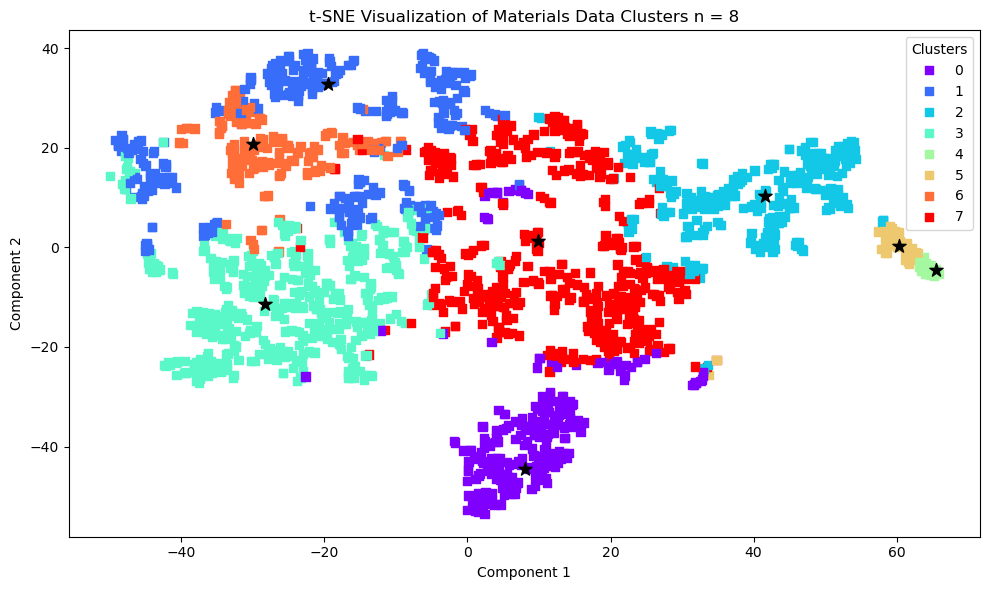

In [13]:
def TSNE_plot2(n_clusters):
    '''
    This function creates a t-SNE scatter plot with cluster color coding.

    Parameters
    ----------
    n_clusters : integer
        The number of clusters to create

    '''
    # get data
    clusters, X, X_scaled, centroids = kmeans_cluster(materials_data, all_features,n_clusters)
    
    # Perform t-SNE
    tnse = TSNE(n_components=2, random_state=0)
    
    # sample 2000 rows from X_scaled and ensure the same indices for clusters
    sample_indices = np.random.choice(X_scaled.shape[0], size=2000, replace=False)
    X_scaled_sample = X_scaled[sample_indices]
    clusters_sample = clusters[sample_indices]
    
    # apply t-SNE
    X_tnse = tnse.fit_transform(X_scaled_sample)
    
    # create DataFrame for plotting
    df_tnse = pd.DataFrame(data=X_tnse, columns=['C1', 'C2'])
    df_tnse['cluster'] = clusters_sample
    
    # plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_tnse['C1'], df_tnse['C2'], c=df_tnse['cluster'], marker='s', cmap='rainbow')
    
    # to visualize centroids, transform centroids to the t-SNE space.
    all_data = np.concatenate([X_scaled_sample, centroids])
    all_data_tnse = tnse.fit_transform(all_data)
    legend = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")

    # extract the transformed centroids
    centroids_tnse = all_data_tnse[-centroids.shape[0]:]
    
    # plot centroids
    plt.scatter(centroids_tnse[:, 0], centroids_tnse[:, 1], marker='*', s=100, linewidths=1, zorder=1, c='black')
    
    # ddd labels
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f't-SNE Visualization of Materials Data Clusters n = {n_clusters}')

    # save fig
    plt.tight_layout()
    plt.savefig(f'TNSE_plot2_{n_clusters}_clusters.png', dpi=300)
    plt.show()

TSNE_plot2(8)

Here we've created 8 clusters. Lets evaluate our model's performance using the silhouette score.

In [14]:
def silouette_score(n_clusters):
    '''
    This function gives the silouette score of our clustering algorithm.

    Parameters
    ----------
    n_clusters : 
    '''
    
    clusters, X, X_scaled, centroids = kmeans_cluster(materials_data, all_features,n_clusters)
    score = metrics.silhouette_score(X, clusters)
    return score
for n in range(2,11,1):
    print(f'{n} Clusters Silouette Score: {silouette_score(n).round(3)}')

2 Clusters Silouette Score: 0.204
3 Clusters Silouette Score: -0.019
4 Clusters Silouette Score: 0.07
5 Clusters Silouette Score: -0.094
6 Clusters Silouette Score: -0.183
7 Clusters Silouette Score: -0.215
8 Clusters Silouette Score: -0.216
9 Clusters Silouette Score: -0.193
10 Clusters Silouette Score: -0.21


As we can see, this data is not great for clustering, with the best score being 0.204 (2 clusters). Lets plot some of the clusters to see how they differ.

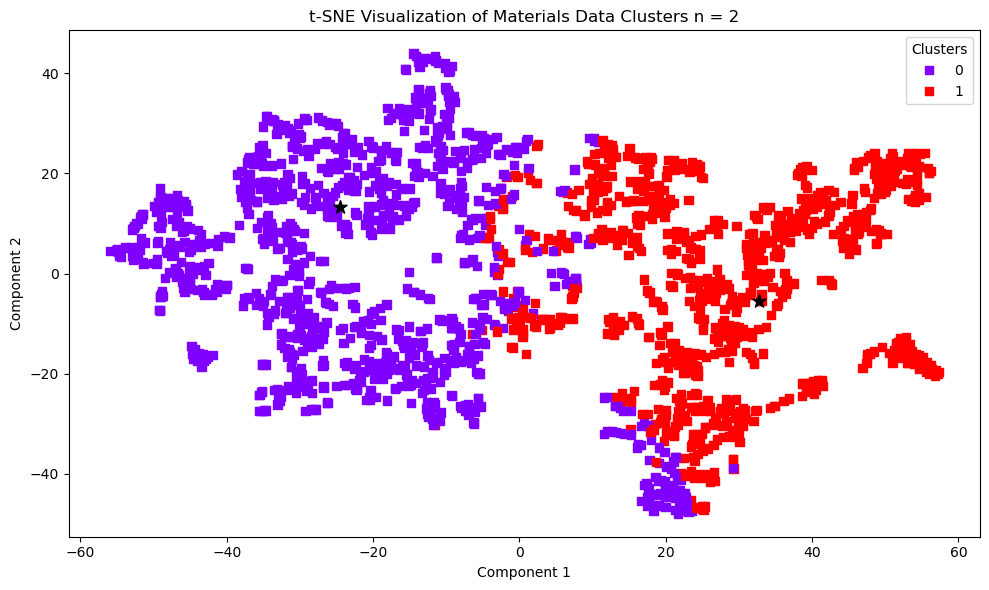

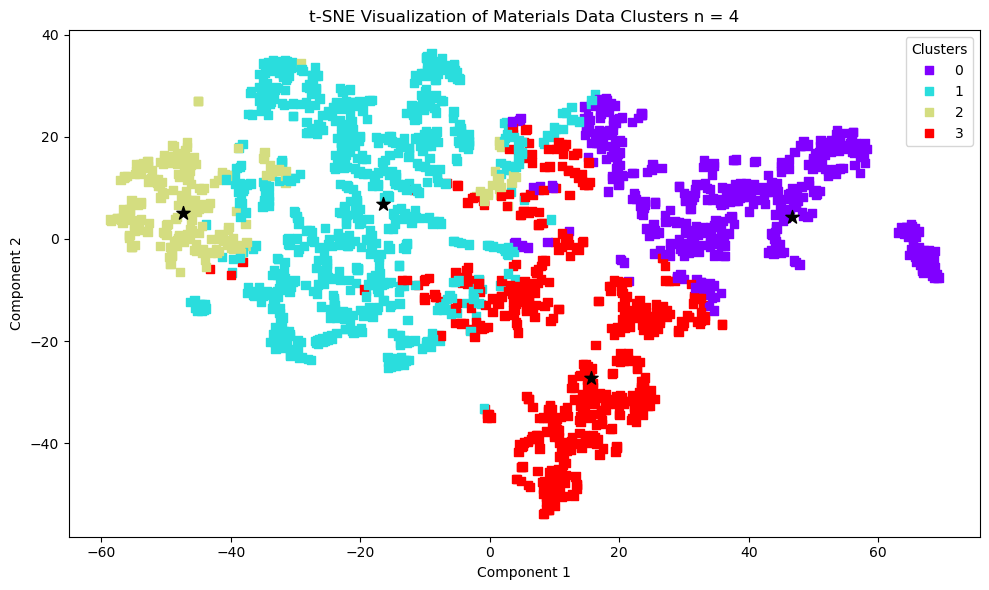

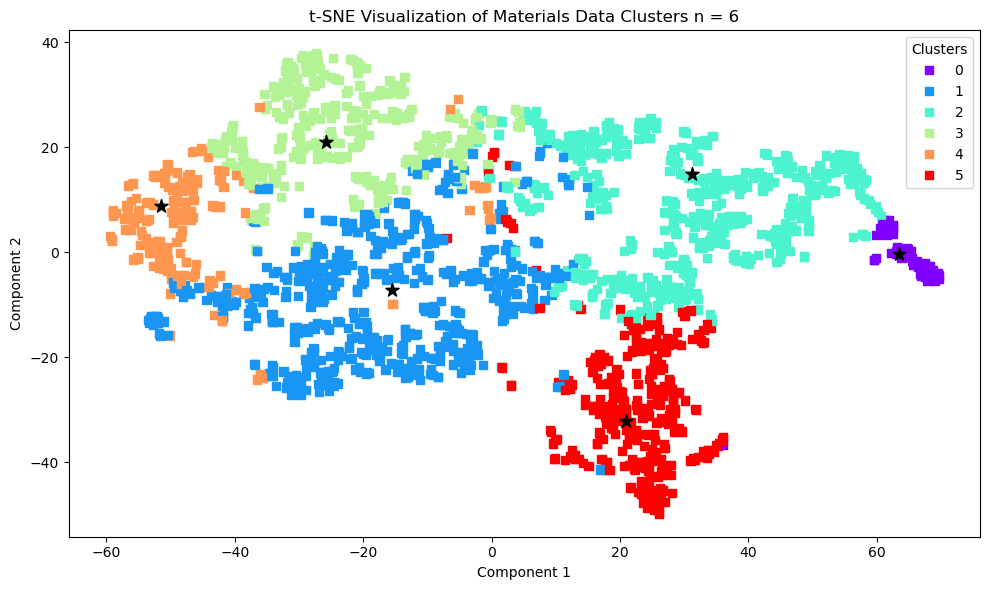

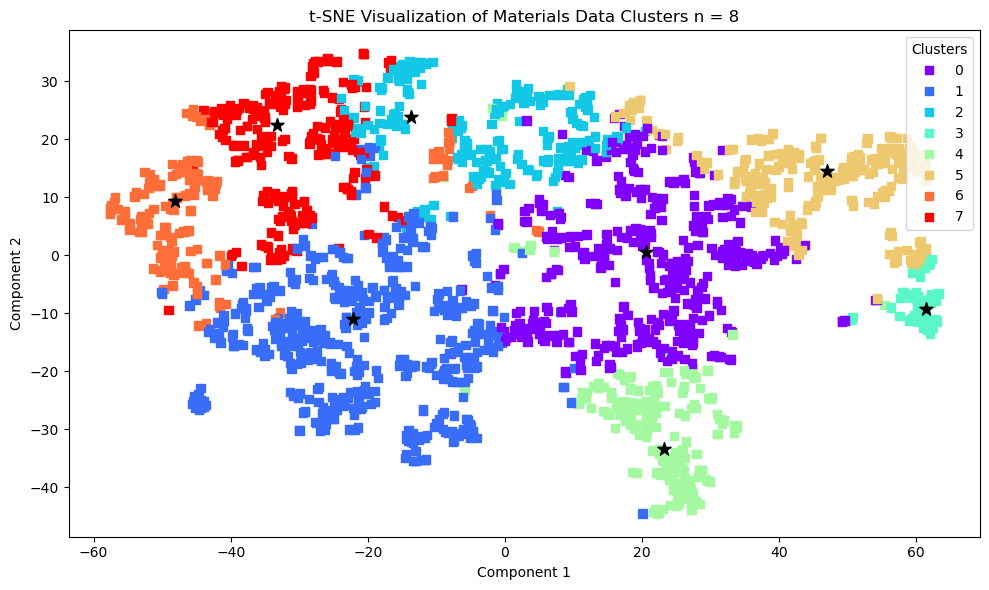

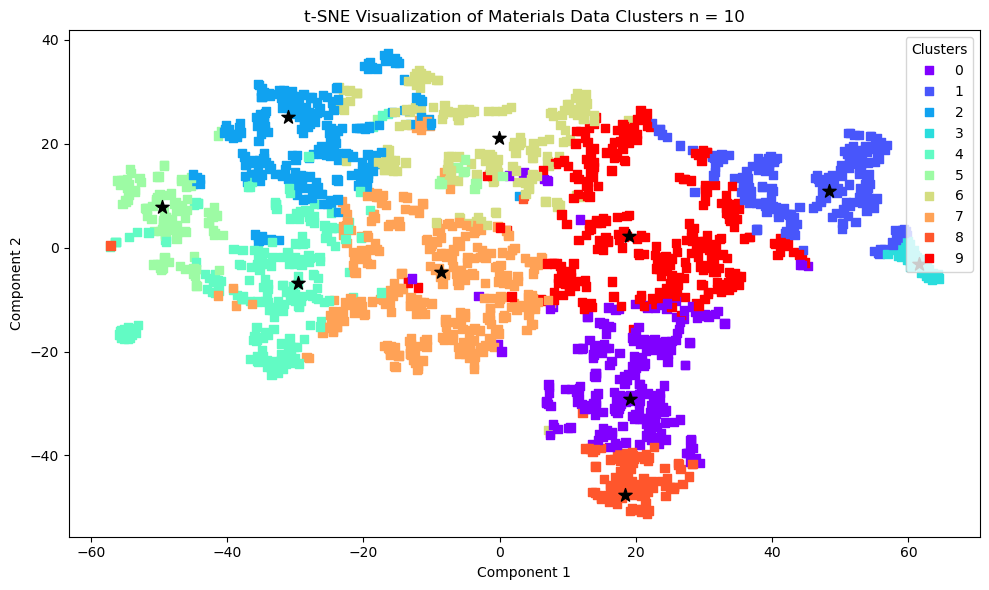

In [15]:
TSNE_plot2(2)
TSNE_plot2(4)
TSNE_plot2(6)
TSNE_plot2(8)
TSNE_plot2(10)

The reason this data is difficult to cluster is most likely because data points are grouped too closely together to create meaningful clusters.